In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


In [44]:
df = pd.read_csv("../dataset/carbon_emission_final_engineered.csv")
print("Original Shape:", df.shape)

# Drop helper or classification columns
drop_cols = ['co2_per_km', 'co2_per_litre', 'efficiency_score', 'high_emitter',
             'low_efficiency', 'co2_tier']
df.drop(columns=[col for col in drop_cols if col in df.columns], inplace=True)


Original Shape: (2109, 27)


In [45]:
"""# %%
def add_more_real_world_noise(df):
    noisy_df = df.copy()
    np.random.seed(42)

    noisy_df['average_speed_in_km_per_hr'] *= np.random.normal(1.0, 0.12, size=len(df))
    noisy_df['no_of_stop'] += np.random.randint(-2, 3, size=len(df))
    noisy_df['load_factor'] *= np.random.normal(1.0, 0.08, size=len(df))
    noisy_df['adjusted_fuel_efficiency_in_km_litre'] *= np.random.normal(1.0, 0.18, size=len(df))
    noisy_df['adjusted_energy_kwh_per_km'] *= np.random.normal(1.0, 0.18, size=len(df))
    noisy_df['fuel_per_km'] *= np.random.normal(1.0, 0.12, size=len(df))
    noisy_df['total_energy_kwh'] *= np.random.normal(1.0, 0.10, size=len(df))
    noisy_df['c02_emission_kg'] *= np.random.normal(1.0, 0.06, size=len(df))  # inject in target

    # Clamp
    noisy_df['load_factor'] = noisy_df['load_factor'].clip(0.1, 1.0)
    noisy_df['no_of_stop'] = noisy_df['no_of_stop'].clip(lower=0)
    noisy_df['adjusted_fuel_efficiency_in_km_litre'] = noisy_df['adjusted_fuel_efficiency_in_km_litre'].clip(lower=1.0)

    return noisy_df

# Apply noise
df = add_more_real_world_noise(df)"""


"# %%\ndef add_more_real_world_noise(df):\n    noisy_df = df.copy()\n    np.random.seed(42)\n\n    noisy_df['average_speed_in_km_per_hr'] *= np.random.normal(1.0, 0.12, size=len(df))\n    noisy_df['no_of_stop'] += np.random.randint(-2, 3, size=len(df))\n    noisy_df['load_factor'] *= np.random.normal(1.0, 0.08, size=len(df))\n    noisy_df['adjusted_fuel_efficiency_in_km_litre'] *= np.random.normal(1.0, 0.18, size=len(df))\n    noisy_df['adjusted_energy_kwh_per_km'] *= np.random.normal(1.0, 0.18, size=len(df))\n    noisy_df['fuel_per_km'] *= np.random.normal(1.0, 0.12, size=len(df))\n    noisy_df['total_energy_kwh'] *= np.random.normal(1.0, 0.10, size=len(df))\n    noisy_df['c02_emission_kg'] *= np.random.normal(1.0, 0.06, size=len(df))  # inject in target\n\n    # Clamp\n    noisy_df['load_factor'] = noisy_df['load_factor'].clip(0.1, 1.0)\n    noisy_df['no_of_stop'] = noisy_df['no_of_stop'].clip(lower=0)\n    noisy_df['adjusted_fuel_efficiency_in_km_litre'] = noisy_df['adjusted_fuel_ef

In [46]:
# %%
features = [
    'distance_in_km_per_route', 'vehicle_age_in_years', 'load_factor',
    'no_of_stop', 'average_speed_in_km_per_hr',
    'adjusted_fuel_efficiency_in_km_litre', 'adjusted_energy_kwh_per_km',
    'fuel_per_km', 'total_energy_kwh', 'speed_per_stop', 'load_utilization',
    'vehicle_type', 'fuel_type', 'traffic_condition', 'engine_norm_type',
    'logistics_partner', 'mode'
]
target = 'c02_emission_kg'

X = df[features]
y = df[target]

# Check target range
print(f"Target range: min = {y.min():.2f}, max = {y.max():.2f}, mean = {y.mean():.2f}")


Target range: min = 1.02, max = 1976.41, mean = 138.69


In [47]:
# %%
categorical = ['vehicle_type', 'fuel_type', 'traffic_condition', 'engine_norm_type', 'logistics_partner', 'mode']
numerical = [col for col in X.columns if col not in categorical]

preprocessor = ColumnTransformer([
    ("num", StandardScaler(), numerical),
    ("cat", OneHotEncoder(handle_unknown='ignore'), categorical)
])

model = RandomForestRegressor(
    n_estimators=300,
    max_depth=20,
    min_samples_split=5,
    min_samples_leaf=4,
    random_state=42,
    n_jobs=-1
)

pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("model", model)
])


In [48]:
# %%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)


In [49]:
# %%
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"\n📊 Model Performance:")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R² Score: {r2:.4f}")



📊 Model Performance:
MAE: 15.04
RMSE: 43.13
R² Score: 0.9810


In [50]:
# Error analysis
errors = pd.DataFrame({
    "Actual_Emission": y_test.values,
    "Predicted_Emission": y_pred,
})
errors["Error"] = errors["Actual_Emission"] - errors["Predicted_Emission"]
errors["Absolute_Error"] = errors["Error"].abs()

# Top 10 largest prediction errors
top_errors = errors.sort_values("Absolute_Error", ascending=False)
print("\n🔍 Top 10 Largest Errors:")
print(top_errors.head(10))



🔍 Top 10 Largest Errors:
     Actual_Emission  Predicted_Emission       Error  Absolute_Error
7             509.12          186.876799  322.243201      322.243201
272           613.71          906.534761 -292.824761      292.824761
363          1976.41         1713.894326  262.515674      262.515674
182          1421.21         1207.381307  213.828693      213.828693
109          1793.13         1584.981189  208.148811      208.148811
359           226.65          426.696073 -200.046073      200.046073
316          1917.89         1724.242938  193.647062      193.647062
340           586.73          414.223620  172.506380      172.506380
380           358.64          522.937236 -164.297236      164.297236
188           195.61          349.829532 -154.219532      154.219532


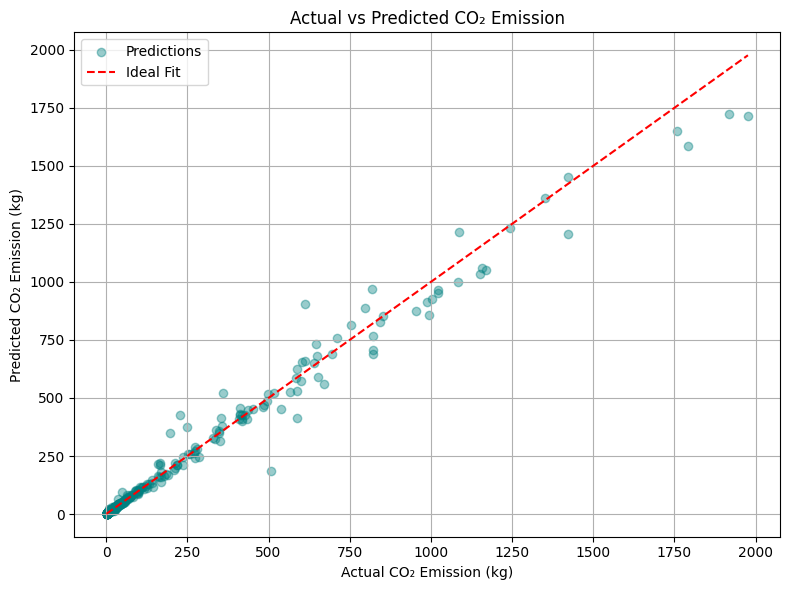

In [51]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.4, color='teal', label='Predictions')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', label='Ideal Fit')
plt.xlabel("Actual CO₂ Emission (kg)")
plt.ylabel("Predicted CO₂ Emission (kg)")
plt.title("Actual vs Predicted CO₂ Emission")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [52]:
def calculate_rule_based_emission(row):
    load_factor = row['load_factor']
    vehicle_age = row['vehicle_age_in_years']
    traffic = row['traffic_condition'].lower()
    distance = row['distance_in_km_per_route']
    fuel_type = row['fuel_type'].lower()
    engine_norm = row.get('engine_norm_type', '').lower()

    load_penalty = 0.05 * (load_factor / 0.9)
    traffic_penalty = {'light': 0, 'medium': 0.05, 'heavy': 0.10}.get(traffic, 0.05)
    age_penalty = 0.01 * vehicle_age
    total_penalty = load_penalty + traffic_penalty + age_penalty

    emission_factors = {
        'bs-iii': 2.4,
        'bs-iv': 2.3,
        'bs-vi': 2.1,
        'diesel': 2.68,
        'jet fuel': 3.16,
        'lng': 2.75,
        'cng': 2.75,
    }

    base_values = {
        'electric': 0.035,
        'hybrid': 0.06,
        'petrol': 45.0,
        'diesel': 20.0,
        'lng': 4.0,
        'cng': 15.0,
        'jet fuel': 0.3,
    }

    if fuel_type == 'electric':
        adjusted_energy = base_values['electric'] * (1 + total_penalty)
        total_energy = adjusted_energy * distance
        return total_energy * 0.82

    elif fuel_type == 'hybrid':
        adjusted_energy = base_values['hybrid'] * (1 + total_penalty)
        total_energy = adjusted_energy * distance
        co2_electric = total_energy * 0.82
        adjusted_fe = base_values['petrol'] * (1 - total_penalty)
        fuel_used = distance / adjusted_fe
        co2_fuel = fuel_used * emission_factors.get(engine_norm, 2.3)
        return co2_electric + co2_fuel

    elif fuel_type == 'petrol':
        adjusted_fe = base_values['petrol'] * (1 - total_penalty)
        fuel_used = distance / adjusted_fe
        return fuel_used * emission_factors.get(engine_norm, 2.3)

    elif fuel_type == 'diesel':
        adjusted_fe = base_values['diesel'] * (1 - total_penalty)
        fuel_used = distance / adjusted_fe
        return fuel_used * emission_factors['diesel']

    elif fuel_type == 'lng':
        adjusted_fe = base_values['lng'] * (1 - total_penalty)
        fuel_used = distance / adjusted_fe
        return fuel_used * emission_factors['lng']

    elif fuel_type == 'cng':
        adjusted_fe = base_values['cng'] * (1 - total_penalty)
        fuel_used = distance / adjusted_fe
        return fuel_used * emission_factors['cng']

    elif fuel_type == 'jet fuel':
        adjusted_fe = base_values['jet fuel'] * (1 - total_penalty)
        fuel_used = distance / adjusted_fe
        return fuel_used * emission_factors['jet fuel']

    return np.nan


In [53]:
# Reset test data index to match predictions
X_test_reset = X_test.reset_index(drop=True)
y_test_reset = y_test.reset_index(drop=True)

# Rule-based predictions
rule_based_pred = X_test_reset.apply(calculate_rule_based_emission, axis=1)

# Combine into a comparison DataFrame
df_compare = pd.DataFrame({
    'actual_emission': y_test_reset,
    'ml_predicted_emission': y_pred,
    'rule_based_emission': rule_based_pred
})

# Calculate errors
df_compare['ml_error'] = np.abs(df_compare['actual_emission'] - df_compare['ml_predicted_emission'])
df_compare['rule_error'] = np.abs(df_compare['actual_emission'] - df_compare['rule_based_emission'])

df_compare.head()


,actual_emission,ml_predicted_emission,rule_based_emission,ml_error,rule_error
0,7.1000,6.062925,4.876469,1.037075,2.223531
1,4.9665,4.986738,5.337145,0.020238,0.370645
2,638.9900,651.590646,659.123463,12.600646,20.133463
3,18.3520,21.315349,18.335970,2.963349,0.016030
4,4.3900,4.960128,2.824567,0.570128,1.565433


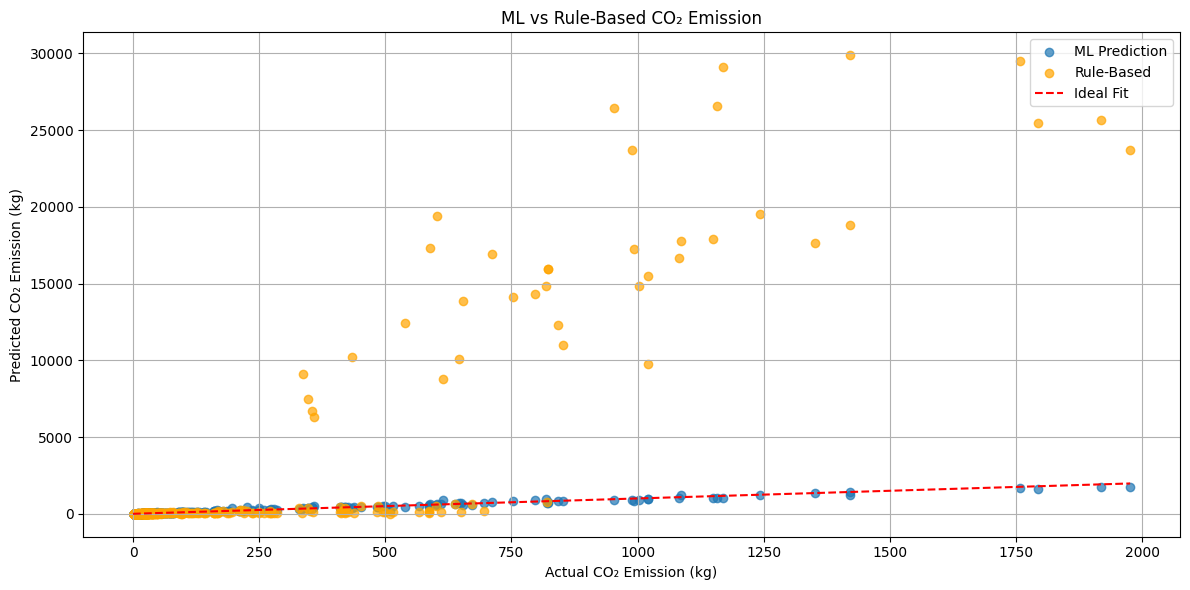

In [54]:
plt.figure(figsize=(12, 6))
plt.scatter(df_compare['actual_emission'], df_compare['ml_predicted_emission'], label='ML Prediction', alpha=0.7)
plt.scatter(df_compare['actual_emission'], df_compare['rule_based_emission'], label='Rule-Based', alpha=0.7, color='orange')
plt.plot([0, df_compare['actual_emission'].max()], [0, df_compare['actual_emission'].max()], 'r--', label='Ideal Fit')

plt.xlabel("Actual CO₂ Emission (kg)")
plt.ylabel("Predicted CO₂ Emission (kg)")
plt.title("ML vs Rule-Based CO₂ Emission")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


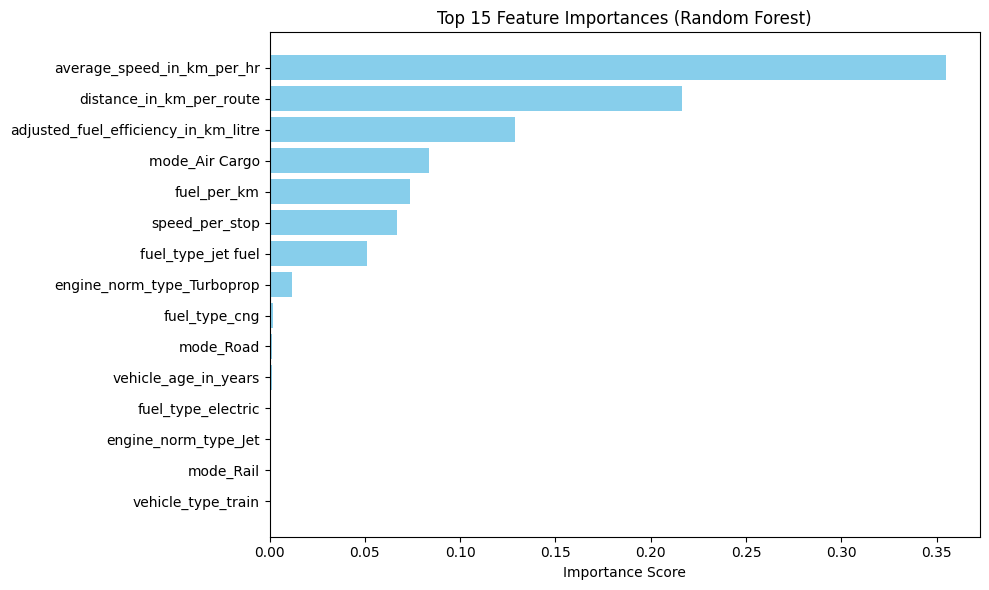

In [55]:
# Get preprocessed feature names
categorical = ['vehicle_type', 'fuel_type', 'traffic_condition', 'engine_norm_type', 'logistics_partner', 'mode']
numerical = [col for col in X.columns if col not in categorical]

# Get feature names after encoding
ohe = pipeline.named_steps['preprocessor'].named_transformers_['cat']
encoded_cat_features = ohe.get_feature_names_out(categorical)

# Combine all features
all_features = numerical + list(encoded_cat_features)

# Get feature importances from the model
importances = pipeline.named_steps['model'].feature_importances_

# Create a DataFrame and sort
importance_df = pd.DataFrame({
    'Feature': all_features,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Plot top 15 features
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'][:15][::-1], importance_df['Importance'][:15][::-1], color='skyblue')
plt.xlabel("Importance Score")
plt.title("Top 15 Feature Importances (Random Forest)")
plt.tight_layout()
plt.show()


In [56]:
"""# %%
# 🧠 Recommendation Logic
def recommend_greener_alternative(row):
    vehicle = row['vehicle_type'].lower()
    emission = row['ml_predicted_emission']

    if emission > 500:
        return "Switch to Rail or Electric Vehicle (if feasible)"
    elif "truck" in vehicle and emission > 200:
        return "Try using Van or Mini-Truck for shorter routes"
    elif "bike" not in vehicle and emission < 50:
        return "Switch to Bike or E-Scooter"
    else:
        return "Current mode is reasonable"

# Add vehicle_type column back into comparison (from X_test)
df_compare['vehicle_type'] = X_test_reset['vehicle_type']
df_compare['recommendation'] = df_compare.apply(recommend_greener_alternative, axis=1)

# %%
# 💡 Estimate Potential Savings (Rule-Based - ML)
df_compare['potential_savings_kg'] = df_compare['rule_based_emission'] - df_compare['ml_predicted_emission']

# Clamp negatives (only count savings where ML was worse)
df_compare['potential_savings_kg'] = df_compare['potential_savings_kg'].apply(lambda x: x if x > 0 else 0)

# %%
# 📊 Summary of Recommendations
print("\n🔁 Recommendation Summary:")
print(df_compare['recommendation'].value_counts())"""



'# %%\n# 🧠 Recommendation Logic\ndef recommend_greener_alternative(row):\n    vehicle = row[\'vehicle_type\'].lower()\n    emission = row[\'ml_predicted_emission\']\n\n    if emission > 500:\n        return "Switch to Rail or Electric Vehicle (if feasible)"\n    elif "truck" in vehicle and emission > 200:\n        return "Try using Van or Mini-Truck for shorter routes"\n    elif "bike" not in vehicle and emission < 50:\n        return "Switch to Bike or E-Scooter"\n    else:\n        return "Current mode is reasonable"\n\n# Add vehicle_type column back into comparison (from X_test)\ndf_compare[\'vehicle_type\'] = X_test_reset[\'vehicle_type\']\ndf_compare[\'recommendation\'] = df_compare.apply(recommend_greener_alternative, axis=1)\n\n# %%\n# 💡 Estimate Potential Savings (Rule-Based - ML)\ndf_compare[\'potential_savings_kg\'] = df_compare[\'rule_based_emission\'] - df_compare[\'ml_predicted_emission\']\n\n# Clamp negatives (only count savings where ML was worse)\ndf_compare[\'potential